In [1]:
import itertools
import os
import pickle

import numpy as np
import pandas as pd
from joblib import delayed
from joblib import Parallel
from ruspy.model_code.cost_functions import lin_cost
if os.environ.get("TRAVIS"):
    pass
else:
    from ruspy.model_code.demand_function import get_demand

from python.auxiliary import get_extensive_specific_sensitivity
from python.auxiliary import get_iskhakov_results
from python.auxiliary import sensitivity_simulation
from python.auxiliary import simulate_data
from python.auxiliary import simulate_figure_3_and_4
from python.auxiliary import transform_grid
from python.auxiliary_figures import get_figure_2
from python.auxiliary_figures import get_figure_3_and_4
from python.auxiliary_figures import get_mse_figure
from python.auxiliary_figures import get_sensitivity_density_both
from python.auxiliary_figures import get_sensitivity_figure
from python.auxiliary_tables import get_table_1
from python.auxiliary_tables import get_table_2

Set the run_simulation below to True if you want to run the simulations instead of relying on the provided results. If you set multiple_cores to True then my major simulation study will be run with the joblib package on multiple cores depending on the amount of cores avaliable. 

In [2]:
run_simulation = False
multiple_cores = False

In case you want to use joblib, you have to run "pip install -e ." when being in the root directory of this repo. This is necessary as I import the loop function for joblib and it does not find it if the repo is not in the environment. For the robustness checks at the very end, I only give the option to use joblib. So, if you want to run those checks (which were not directly part of the thesis results) you would need to pip install the repo in editable mode for sure. 

# Replication
---

This notebook serves to replicate the figures and tables that can be found in my thesis. On top of that, I include some code that I relied on when doing some checks that I refer to in my thesis. Here and there it is necessary to adapt the code in the background as some of the features needed are not publicly available in ruspy yet. I will point you to the necessary changes whenever applicable. The simulations in my thesis took quite long so in some parts I provide the option to either rerun the simulations or just load the results from running them. 

### Table 1

In [3]:
# set up for table 1
discount_factor = [0.975, 0.985, 0.995, 0.999, 0.9995, 0.9999]
approach = ["NFXP", "MPEC"]
starting_cost_params = np.vstack((np.arange(4, 9), np.arange(1, 6)))
starting_expected_value_fun = np.zeros(175)
number_runs = 250
number_buses = 50
number_periods = 120
number_states = 175
number_cost_params = 2

For the creation of the table it is needed to run the simulation as in Iskhakov et al. (2016) with the ruspy package. This took one night on my machine. In the following you can either run the simulation yourself or simply load the results. 

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following code has optional parts.</div>

In [4]:
# get results for table 1
if os.environ.get("TRAVIS") or run_simulation is False:
    # load the results of the previous box
    results = pd.read_pickle("data/get_iskhakov_results")
else:
    results = get_iskhakov_results(
        discount_factor,
        approach,
        starting_cost_params,
        starting_expected_value_fun,
        number_runs,
        number_buses,
        number_periods,
        number_states,
        number_cost_params,
    )

In [5]:
# create table 1
table_1 = get_table_1(results, number_runs, starting_cost_params)
table_1

CPU Time  Converged  # of Major Iter.  \
Discount Factor Approach                                          
0.9750          MPEC      1.150670       1250         19.556000   
                NFXP      1.285970       1250         11.755200   
0.9850          MPEC      1.186541       1250         19.880000   
                NFXP      1.305547       1250         11.356000   
0.9950          MPEC      1.352074       1250         22.165600   
                NFXP      1.185113       1250         10.606400   
0.9990          MPEC      1.612590       1249         25.275420   
                NFXP      1.556095       1250         10.936000   
0.9995          MPEC      1.754072       1248         26.112981   
                NFXP      2.626209       1250         10.921600   
0.9999          MPEC      1.861206       1250         28.148800   
                NFXP      2.778112       1250         10.861600   

                          # of Func. Eval.  # of Bellm. Iter.  # of N-K Iter.  
Discount Factor Approach                                                       
0.9750          MPEC             25.864000                NaN             NaN  
                NFXP             14.121600           301.7328        104.3992  
0.9850          MPEC             28.391200                NaN             NaN  
                NFXP             13.580800           291.1872        105.6200  
0.9950          MPEC             35.076000                NaN             NaN  
                NFXP             12.665600           272.9320         97.7272  
0.9990          MPEC             41.539632                NaN             NaN  
                NFXP             12.924800           278.0248        138.3936  
0.9995          MPEC             43.597756                NaN             NaN  
                NFXP             12.903200           277.5848        250.7456  
0.9999          MPEC             49.267200                NaN             NaN  
                NFXP             12.857600           276.6200        270.0008

### Table 2

In [6]:
# get table 2
my_results_table_2, iskhakov_table_2 = get_table_2(results, discount_factor, approach)
my_results_table_2

RC  theta_11
Discount Factor Approach Statistic                            
0.9750          NFXP     Mean                11.9079   2.50679
                         Standard Deviation   1.5173  0.468413
                MPEC     Mean                11.9079   2.50679
                         Standard Deviation   1.5173  0.468413
0.9850          NFXP     Mean                11.9865   2.53371
                         Standard Deviation  1.45744  0.452172
                MPEC     Mean                11.9865   2.53371
                         Standard Deviation  1.45744  0.452172
0.9950          NFXP     Mean                11.8907   2.50845
                         Standard Deviation  1.38393  0.439881
                MPEC     Mean                11.8907   2.50845
                         Standard Deviation  1.38393   0.43988
0.9990          NFXP     Mean                11.8743   2.51282
                         Standard Deviation   1.3466  0.443834
                MPEC     Mean                11.8737   2.51261
                         Standard Deviation  1.34701   0.44396
0.9995          NFXP     Mean                11.8474   2.50821
                         Standard Deviation  1.34297   0.44513
                MPEC     Mean                11.8494   2.50882
                         Standard Deviation  1.34285  0.445112
0.9999          NFXP     Mean                11.8148   2.49853
                         Standard Deviation  1.31945  0.431024
                MPEC     Mean                11.8147   2.49848
                         Standard Deviation  1.31932  0.430985

In [7]:
iskhakov_table_2

RC  theta_11
Discount Factor Statistic                            
0.9750          Mean                11.9135   2.50835
                Standard Deviation  1.51658  0.468155
0.9850          Mean                11.9911   2.53496
                Standard Deviation   1.4572  0.452003
0.9950          Mean                11.1907   2.90188
                Standard Deviation  1.18759  0.473003
0.9990          Mean                11.8758   2.51329
                Standard Deviation  1.34603   0.44361
0.9995          Mean                11.8491   2.50872
                Standard Deviation  1.34246  0.444898
0.9999          Mean                11.8167   2.49911
                Standard Deviation  1.31881  0.430809

### Figure 2

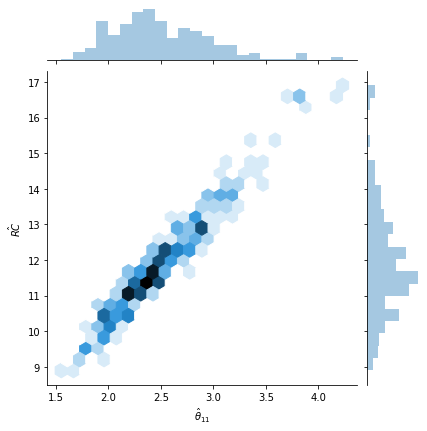

In [8]:
# get figure 2
beta = 0.975
get_figure_2(results, beta)

### Figure 3 and 4

For the following part one has to calculate the demand functions across the Monte Carlo runs from before. This took one hour on my laptop. You can either run the calculation or load the results in the box below.

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following code has optional parts.</div>

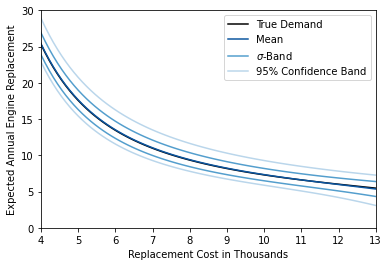

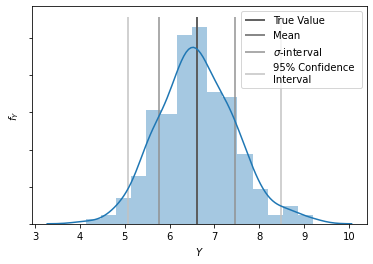

In [9]:
# simulate the demand function over the Monte Carlo runs 
# and get correlation of the estimated parameters as well as Figure 3 and 4 
if os.environ.get("TRAVIS") or run_simulation is False:
    # load the previously simulated results
    names = ["demand", "rc_range", "true_demand", "correlation"]
    temp = {}
    for name in names:
        temp[name] = pd.read_pickle(f"data/{name}.pickle")
    get_figure_3_and_4(temp["demand"], temp["rc_range"], temp["true_demand"])
else:
    demand, rc_range, true_demand, correlation = simulate_figure_3_and_4(
        results, beta, number_states, number_buses
    )
    get_figure_3_and_4(demand, rc_range, true_demand)

### Table 3

In [10]:
temp["correlation"]

,RC,theta_11,theta_30,theta_31,theta_32,theta_33
RC,1.000000,0.971539,-0.041474,-0.011070,0.001105,0.153098
theta_11,0.971539,1.000000,-0.022371,-0.025008,0.005899,0.144094
theta_30,-0.041474,-0.022371,1.000000,-0.256231,-0.309146,-0.070090
theta_31,-0.011070,-0.025008,-0.256231,1.000000,-0.815378,-0.062086
theta_32,0.001105,0.005899,-0.309146,-0.815378,1.000000,-0.117790
theta_33,0.153098,0.144094,-0.070090,-0.062086,-0.117790,1.000000


## My own Simulation

In the first part one has to simulate the data sets for which the parameters are calibrated. This first step is done in the box which does not take too long to execute but still you can either run it yourself or load the results. 

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following code has optional parts.</div>

In [11]:
if os.environ.get("TRAVIS") or run_simulation is False:
    # load the data sets
    simulated_data_400 = pickle.load(open("data/simulated_data_400.pickle", "rb"))
    simulated_data_200 = pickle.load(open("data/simulated_data_200.pickle", "rb"))
    simulated_data_100 = pickle.load(open("data/simulated_data_100.pickle", "rb"))
else:
    # get simulated data on which the sensitivity analysis is applied,
    # set up for simulation of data sets
    disc_fac = 0.975
    num_buses = 50
    num_periods = 120
    num_states = 400
    number_cost_params = 2
    cost_params = np.array([11.7257, 2.4569])
    trans_params = np.array(
        [
            0.0937 / 2,
            0.0937 / 2,
            0.4475 / 2,
            0.4475 / 2,
            0.4459 / 2,
            0.4459 / 2,
            0.0127 / 2,
            0.0127 / 2,
            0.0002 / 2,
            0.0002 / 2,
        ]
    )
    scale = 1e-3

    # simulate data sets with grid size 400
    np.random.seed(123)
    seeds = np.random.randint(1000, 1000000, 250)
    simulated_data_400 = []
    for seed in seeds:
        df = simulate_data(
            seed,
            disc_fac,
            num_buses,
            num_periods,
            num_states,
            cost_params,
            trans_params,
            lin_cost,
            scale,
        )
        simulated_data_400.append(df)

    # derive smaller gird size data sets from that
    simulated_data_200 = []
    simulated_data_100 = []
    for data in simulated_data_400:
        data_200 = data.copy().apply(transform_grid)
        simulated_data_200.append(data_200)
        simulated_data_100.append(data_200.copy().apply(transform_grid))

    # transform all data sets such that usage is correct
    for data_list in [simulated_data_100, simulated_data_200, simulated_data_400]:
        for data in data_list:
            data["usage"][1:] = (
                data["state"][1:].astype(int).to_numpy()
                - data["state"][:-1].astype(int).to_numpy()
            )
            data.reset_index(inplace=True)
            replacements = data.loc[data["decision"] == 1].index + 1
            data.loc[data.index.intersection(replacements), "usage"] = data.reindex(
                replacements
            )["state"]
            data.set_index(["Bus_ID", "period"], drop=True, inplace=True)
            data.loc[(slice(None), 0), "usage"] = np.nan

In the following we need to calibrate the parameters for many different model specifications. This simulation in the box below probably takes around three nights. Within the box you can either run the simulation with multiple cores using joblib or regularly as a for loop with a single core. Once there is a simulation in which I use MPEC and NFXP with the BHHH. Then after that there is the same simulation using just NFXP with L-BFGS-B. You can either run it yourself or load the results below. 

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following code has optional parts.</div>

In [12]:
if os.environ.get("TRAVIS") or run_simulation is False:
    # load data
    sensitivity_results_bhhh = pd.read_pickle("data/sensitivity_results_full_bhhh.pickle")
    sensitivity_results_lbfgsb = pd.read_pickle(
        "data/sensitivity_results_full_lbfgsb.pickle"
    )
else:
    # run sensitivity analysis 

    # set up specifications for which the simulated data sets should be estimated
    # changing specifications
    discount_factors = [0.975, 0.985]
    cost_functions = ["linear", "quadratic", "cubic"]
    scales = [1e-3, 1e-5, 1e-8]
    grid_sizes = [100, 200, 400]
    gradients = ["Yes", "No"]
    approaches = ["NFXP", "MPEC"]
    specifications = list(
        itertools.product(
            discount_factors, zip(cost_functions, scales), grid_sizes, gradients, approaches
        )
    )
    specifications = list(zip(specifications, np.arange(len(specifications))))

    # fixed specifications
    number_runs = 250

    # EITHER
    # run the extensive simulation with multiple cores using the BHHH for NFXP and MPEC
    # only works if before pip install -e . when being in the thesis directory
    if multiple_cores is True:
        sensitivity_results_bhhh = Parallel(n_jobs=os.cpu_count(), verbose=50)(
            delayed(sensitivity_simulation)(specification, number_runs, "estimagic_bhhh")
            for specification in specifications
        )
    else:
        # OR alternatively normal run without joblib
        sensitivity_results_bhhh = []
        for specification in specifications:
            sensitivity_results_bhhh.append(
                sensitivity_simulation(specification, number_runs, "estimagic_bhhh")
            )
    # translate the results in correct form
    results_temp = sensitivity_results_bhhh[0]
    for result in sensitivity_results_bhhh[1:]:
        results_temp = pd.concat((results_temp, result))
    sensitivity_results_bhhh = results_temp

    # add the simulation for NFXP with the scipy L-BFGS-B
    discount_factors = [0.975, 0.985]
    cost_functions = ["linear", "quadratic", "cubic"]
    scales = [1e-3, 1e-5, 1e-8]
    grid_sizes = [100, 200, 400]
    gradients = ["Yes", "No"]
    approaches = ["NFXP"]
    specifications = list(
        itertools.product(
            discount_factors, zip(cost_functions, scales), grid_sizes, gradients, approaches
        )
    )
    specifications = list(zip(specifications, np.arange(len(specifications))))
    
    # fixed specifications
    number_runs = 250

    # only works if before pip install -e . when being in the thesis directory
    if multiple_cores is True:
        sensitivity_results_lbfgsb = Parallel(n_jobs=os.cpu_count(), verbose=50)(
            delayed(sensitivity_simulation)(specification, number_runs, "scipy_L-BFGS-B")
            for specification in specifications
        )
    else:
        # or alternatively normal run without joblib
        sensitivity_results_lbfgsb = []
        for specification in specifications:
            sensitivity_results_lbfgsb.append(
                sensitivity_simulation(specification, number_runs, "scipy_L-BFGS-B")
            )
            
    # translate the results in correct form
    results_temp = pd.concat((sensitivity_results_lbfgsb[0], 
                              sensitivity_results_bhhh.loc(axis=0)[
                                  :, :, :, :, "MPEC", :].iloc[0:number_runs]))
    for number, result in enumerate(sensitivity_results_lbfgsb[1:]):
        both = pd.concat((result, sensitivity_results_bhhh.loc(axis=0)[
                                  :, :, :, :, "MPEC", :].iloc[
                                      (number+1)*number_runs:(number+2)*number_runs]))
        results_temp = pd.concat((results_temp, both))
    sensitivity_results_lbfgs = results_temp

### Table 4

In [13]:
# set up specifications for which the simulated data sets should be estimated
# changing specifications
discount_factors = [0.975, 0.985]
cost_functions = ["linear", "quadratic", "cubic"]
grid_sizes = [100, 200, 400]
gradients = ["Yes", "No"]
specifications = list(
    itertools.product(
        discount_factors, cost_functions, grid_sizes, gradients,
    )
)
specifications

[(0.975, 'linear', 100, 'Yes'),
 (0.975, 'linear', 100, 'No'),
 (0.975, 'linear', 200, 'Yes'),
 (0.975, 'linear', 200, 'No'),
 (0.975, 'linear', 400, 'Yes'),
 (0.975, 'linear', 400, 'No'),
 (0.975, 'quadratic', 100, 'Yes'),
 (0.975, 'quadratic', 100, 'No'),
 (0.975, 'quadratic', 200, 'Yes'),
 (0.975, 'quadratic', 200, 'No'),
 (0.975, 'quadratic', 400, 'Yes'),
 (0.975, 'quadratic', 400, 'No'),
 (0.975, 'cubic', 100, 'Yes'),
 (0.975, 'cubic', 100, 'No'),
 (0.975, 'cubic', 200, 'Yes'),
 (0.975, 'cubic', 200, 'No'),
 (0.975, 'cubic', 400, 'Yes'),
 (0.975, 'cubic', 400, 'No'),
 (0.985, 'linear', 100, 'Yes'),
 (0.985, 'linear', 100, 'No'),
 (0.985, 'linear', 200, 'Yes'),
 (0.985, 'linear', 200, 'No'),
 (0.985, 'linear', 400, 'Yes'),
 (0.985, 'linear', 400, 'No'),
 (0.985, 'quadratic', 100, 'Yes'),
 (0.985, 'quadratic', 100, 'No'),
 (0.985, 'quadratic', 200, 'Yes'),
 (0.985, 'quadratic', 200, 'No'),
 (0.985, 'quadratic', 400, 'Yes'),
 (0.985, 'quadratic', 400, 'No'),
 (0.985, 'cubic', 100, 'Y

In the following figures I rely on knowledge about the true counterfactual demand level for my simulation study. This demand level is obtained below

In [14]:
if os.environ.get("TRAVIS"):
    pass
else:
    # Get the true demand (the true QoI) of the underlying data generating process
    cost_params = np.array([11.7257, 2.4569])
    trans_params = np.array(
        [
            0.0937 / 2,
            0.0937 / 2,
            0.4475 / 2,
            0.4475 / 2,
            0.4459 / 2,
            0.4459 / 2,
            0.0127 / 2,
            0.0127 / 2,
            0.0002 / 2,
            0.0002 / 2,
        ]
    )
    demand_params = np.concatenate((trans_params, cost_params))
    init_dict = {
        "model_specifications": {
            "discount_factor": 0.975,
            "number_states": 400,
            "maint_cost_func": "linear",
            "cost_scale": 1e-3,
        },
    }
    demand_dict = {
        "RC_lower_bound": 11,
        "RC_upper_bound": 11,
        "demand_evaluations": 1,
        "tolerance": 1e-10,
        "num_periods": 12,
        "num_buses": 50,
    }
    true_demand = (
        get_demand(init_dict, demand_dict, demand_params)["demand"]
        .astype(float)
        .to_numpy()[0]
    )
    true_demand

11.095184215630066

### Figure 5

No handles with labels found to put in legend.


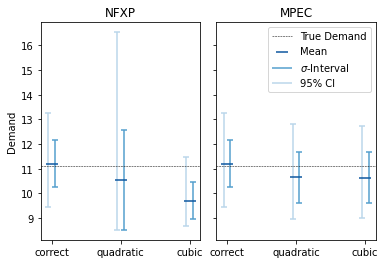

In [15]:
# only cost
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.975, "quadratic", 400, "Yes"],
    [0.975, "cubic", 400, "Yes"],
]
labels = ["correct", "quadratic", "cubic"]
figure_name = "5"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_sensitivity_figure(
    sensitivity_data, specifications, labels, figure_name, legend=True
)

### Figure 6

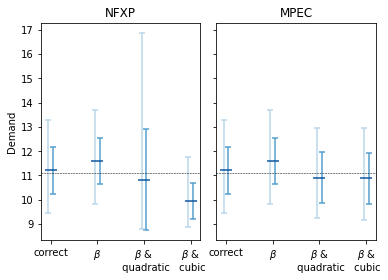

In [16]:
# cost and discount factor
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.985, "linear", 400, "Yes"],
    [0.985, "quadratic", 400, "Yes"],
    [0.985, "cubic", 400, "Yes"],
]
labels = ["correct", r"$\beta$", r"$\beta$" " &\n quadratic", r"$\beta$" " &\n cubic"]
figure_name = "6"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_sensitivity_figure(sensitivity_data, specifications, labels, figure_name)

### Figure 7

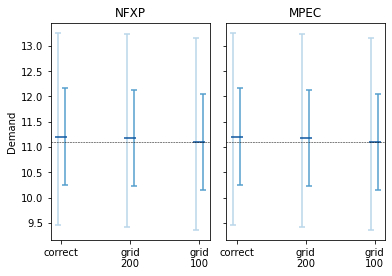

In [17]:
# just grid size
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.975, "linear", 200, "Yes"],
    [0.975, "linear", 100, "Yes"],
]
labels = ["correct", "grid\n200", "grid\n100"]
figure_name = "7"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_sensitivity_figure(sensitivity_data, specifications, labels, figure_name)

### Figure 8

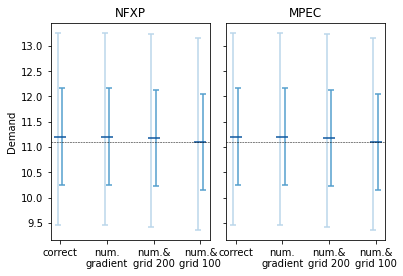

In [18]:
# gradient and grid size
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.975, "linear", 400, "No"],
    [0.975, "linear", 200, "No"],
    [0.975, "linear", 100, "No"],
]
labels = ["correct", "num.\ngradient", "num.&\ngrid 200", "num.&\ngrid 100"]
figure_name = "8"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_sensitivity_figure(sensitivity_data, specifications, labels, figure_name)

### Table 4

In [19]:
sensitivity_data.loc[(slice(None), slice(None), slice(None), slice(None), slice(None), "Mean"), 
                    slice("CPU Time", "# of N-K Iter.")]

CPU Time  \
Discount Factor Cost Function Grid Size Analytical Gradient Approach Statistic               
0.975           linear        400       Yes                 NFXP     Mean         7.381086   
                                                            MPEC     Mean        23.129314   
                                        No                  NFXP     Mean        16.430282   
                                                            MPEC     Mean       168.394828   
                              200       No                  NFXP     Mean         3.719552   
                                                            MPEC     Mean        26.366221   
                              100       No                  NFXP     Mean         1.185391   
                                                            MPEC     Mean         4.439239   

                                                                                Converged  \
Discount Factor Cost Function Grid Size Analytical Gradient Approach Statistic              
0.975           linear        400       Yes                 NFXP     Mean             1.0   
                                                            MPEC     Mean             1.0   
                                        No                  NFXP     Mean             1.0   
                                                            MPEC     Mean             1.0   
                              200       No                  NFXP     Mean             1.0   
                                                            MPEC     Mean             1.0   
                              100       No                  NFXP     Mean             1.0   
                                                            MPEC     Mean             1.0   

                                                                                # of Major Iter.  \
Discount Factor Cost Function Grid Size Analytical Gradient Approach Statistic                     
0.975           linear        400       Yes                 NFXP     Mean                 11.728   
                                                            MPEC     Mean                 18.684   
                                        No                  NFXP     Mean                 11.728   
                                                            MPEC     Mean                 19.132   
                              200       No                  NFXP     Mean                 14.016   
                                                            MPEC     Mean                 22.096   
                              100       No                  NFXP     Mean                 12.352   
                                                            MPEC     Mean                 21.556   

                                                                                # of Func. Eval.  \
Discount Factor Cost Function Grid Size Analytical Gradient Approach Statistic                     
0.975           linear        400       Yes                 NFXP     Mean                 13.252   
                                                            MPEC     Mean                 23.752   
                                        No                  NFXP     Mean                 13.252   
                                                            MPEC     Mean                 24.632   
                              200       No                  NFXP     Mean                 15.016   
                                                            MPEC     Mean                 28.008   
                              100       No                  NFXP     Mean                 13.824   
                                                            MPEC     Mean                 31.504   

                                                                                # of Func. Eval. (Total)  \
Discount Factor Cost Function Grid Size Analytical Gradient Approach Statistic                      

### Figure 9

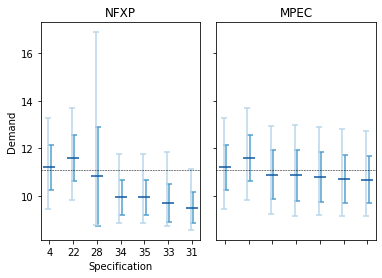

In [20]:
# all together
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.985, "linear", 400, "Yes"],
    [0.985, "quadratic", 400, "Yes"],
    [0.985, "cubic", 400, "Yes"],
    [0.985, "cubic", 400, "No"],
    [0.985, "cubic", 200, "No"],
    [0.985, "cubic", 100, "No"],
]
labels = len(specifications) * [""]
figure_name = "9"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_sensitivity_figure(sensitivity_data, specifications, labels, figure_name)

### Figure 10

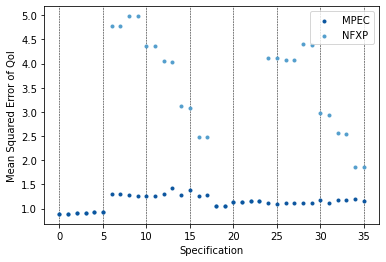

In [21]:
# get MSE figure
discount_factors = [0.975, 0.985]
cost_functions = ["linear", "quadratic", "cubic"]
grid_sizes = [100, 200, 400]
gradients = ["Yes", "No"]
specs = list(itertools.product(discount_factors, cost_functions, grid_sizes, gradients))
specifications = []
for spec in specs:
    specifications.append(list(spec))
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_lbfgsb, specifications
)[1]
get_mse_figure(sensitivity_data, specifications, "figure_10")

### Figure 11

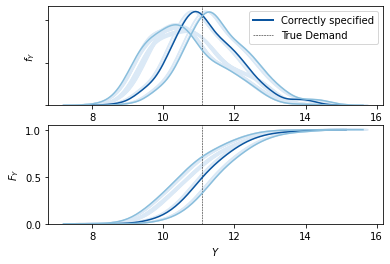

In [22]:
# look at the distributions of the QoI per specification for MPEC
get_sensitivity_density_both(
    sensitivity_results_lbfgsb, "MPEC", "figure_11", np.arange(72), mark=[27, 45]
)

### Figure 12

No handles with labels found to put in legend.


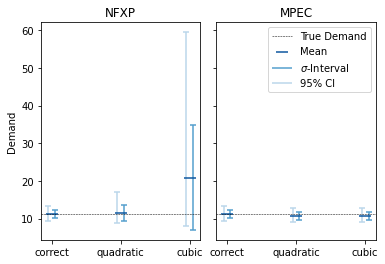

In [23]:
# get figure 5 using the NFXP with BHHH instead of L-BFGS-B
specifications = [
    [0.975, "linear", 400, "Yes"],
    [0.975, "quadratic", 400, "Yes"],
    [0.975, "cubic", 400, "Yes"],
]
labels = ["correct", "quadratic", "cubic"]
figure_name = "12"
sensitivity_data = get_extensive_specific_sensitivity(
    sensitivity_results_bhhh, specifications
)[1]
get_sensitivity_figure(
    sensitivity_data, specifications, labels, figure_name, legend=True
)

### Figure 13

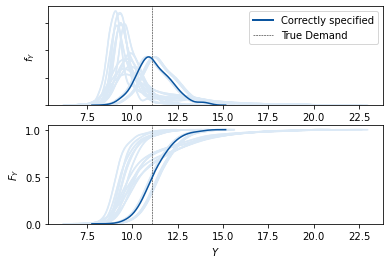

In [24]:
# look at the distributions of the QoI per specification for NFXP with L-BFGS-B
get_sensitivity_density_both(
    sensitivity_results_lbfgsb, "NFXP", "figure_13", np.arange(72), mark=[27, 45]
)

### Additional Tests

In the next bit I test how the results of my simulation change when using different stopping tolerances for the NFXP with L-BFGS-B. For that I rerun the first 5 runs for each specification which does not take too long but a few minutes.

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following code has optional parts.</div>

In [25]:
if os.environ.get("TRAVIS") or run_simulation is False:
    pass
else:
    # test lbfgsb with different tolerances
    # get tolerances
    base=10
    level=np.ones(10)
    for i in np.arange(10):
        base=base*100
        level[i] = level[i]/base

    # get setup for the simulation
    discount_factors = [0.975, 0.985]
    cost_functions = ["linear", "quadratic", "cubic"]
    scales = [1e-3, 1e-5, 1e-8]
    grid_sizes = [100, 200, 400]
    gradients = ["Yes", "No"]
    approaches = ["NFXP"]
    specifications = list(
        itertools.product(
            discount_factors, zip(cost_functions, scales), grid_sizes, gradients, approaches
        )
    )
    specifications = list(zip(specifications, np.arange(len(specifications))))
    # fixed specifications
    number_runs = 5

    # run simulation with joblib 
    sensitivity_results={}
    for tol in level: 
        # only works if before pip install -e . when being in the thesis directory
        sensitivity_results[str(tol)] = Parallel(n_jobs=os.cpu_count(), verbose=50)(
            delayed(sensitivity_simulation)(specification, number_runs, "scipy_L-BFGS-B",
                                            tolerance={"gtol": tol})
            for specification in specifications
        )

    # make results more readable     
    for tol in level:
        temp = sensitivity_results[str(tol)].copy()
        sensitivity_results[str(tol)] = temp[0]
        for data in temp[1:]:
            sensitivity_results[str(tol)]=sensitivity_results[str(tol)].append(data)

Now I do so again for the BHHH with the NFXP. 

In [26]:
if os.environ.get("TRAVIS") or run_simulation is False:
    pass
else:
    # test BHHH with other tolerances
    level = [
        (1e-03, 1e-06),
        (1e-05, 1e-08),
        (1e-07, 1e-10),
        (1e-09, 1e-12),
        (1e-11, 1e-14),
        (1e-13, 1e-16),
        ]

    # run simulation with joblib
    sensitivity_results={}
    for tol in level: 
        # only works if before pip install -e . when being in the thesis directory
        sensitivity_results[str(tol)] = Parallel(n_jobs=os.cpu_count(), verbose=50)(
            delayed(sensitivity_simulation)(specification, number_runs, "estimagic_bhhh",
                                            tolerance={"tol": {"abs": tol[0], "rel": tol[1]}})
            for specification in specifications
        )

    # make results more readable
    for tol in level:
        temp = sensitivity_results[str(tol)].copy()
        sensitivity_results[str(tol)] = temp[0]
        for data in temp[1:]:
            sensitivity_results[str(tol)]=sensitivity_results[str(tol)].append(data)

Lastly, I test whether it makes a difference that the NFXP can use twice as many contraction and N-K steps as before. I test this for both L-BFGS-B and BHHH in their default settings below. 

In [27]:
if os.environ.get("TRAVIS") or run_simulation is False:
    pass
else:
    # check for number of contraction and N-K steps
    sensitivity_results = Parallel(n_jobs=os.cpu_count(), verbose=50)(
        delayed(sensitivity_simulation)(specification, number_runs, "scipy_L-BFGS-B",
                                        max_cont=40, max_nk=40)
        for specification in specifications
    )

    sensitivity_results = Parallel(n_jobs=os.cpu_count(), verbose=50)(
        delayed(sensitivity_simulation)(specification, number_runs, "estimagic_bhhh",
                                        max_cont=40, max_nk=40)
        for specification in specifications
    )